# Importação de bibliotecas

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score,silhouette_score
import xgboost as xgb
from sklearn.cluster import DBSCAN, AgglomerativeClustering
import os
import requests
from zipfile import ZipFile
from urllib.request import urlopen
from io import BytesIO
from sklearn.preprocessing import LabelEncoder,StandardScaler



# Funções auxiliares

Função para remoção de outliers

In [4]:
# Tratamento de outliers usando o método do IQR
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

Funções para: 1. Download de txt ; 2. Download, descompactação e armazenamento de .zip

In [5]:

def baixar_arquivo_txt(url, data_directory, nome_arquivo):
    os.makedirs(data_directory, exist_ok=True)
    resposta = requests.get(url)
    caminho_arquivo = os.path.join(data_directory, nome_arquivo)
    with open(caminho_arquivo, 'wb') as f:
        f.write(resposta.content)

def download_and_unzip(url, data_directory, nome_arquivo):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    caminho_arquivo = os.path.join(data_directory, nome_arquivo)
    zipfile.extractall(path=caminho_arquivo)

# Leitura dos dados

## Importação dos dados necessários direto da URL indicada

'Inclua no seu trabalho o comando para baixar esses dois conjuntos de dados e guardá-los em memória.'

In [6]:
# Importando arquivo de descrição do dataset. Baixando o arquivo zip com os dados e descompactando-o em 'data/'
downloadFlag = False
links = [
    'https://files.grouplens.org/datasets/movielens/ml-1m.zip',
    'https://files.grouplens.org/datasets/movielens/ml-1m-README.txt'
]
nomes_arquivos = ['', 'ml-1m-README.txt']
directory = 'data'

if downloadFlag:
    print("Baixando arquivo de descrição do dataset e o arquivo zip com os dados...")
    baixar_arquivo_txt(links[1], data_directory = directory, nome_arquivo = nomes_arquivos[1])

    download_and_unzip(links[0], data_directory = directory, nome_arquivo = nomes_arquivos[0])

## Leitura dos dados necessários

Foi indicado que apenas seriam usados: 1. 'u.data' ; 2. 'u.item'

In [7]:
movies_df = pd.read_csv(
    os.path.join(directory, 'ml-1m', 'movies.dat'),
    sep='::',
    engine='python',
    names=['MovieID', 'Title', 'Genres'],
    encoding='latin-1'
)

In [8]:
movies_df

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [9]:
ratings_df = pd.read_csv(
    os.path.join(directory, 'ml-1m', 'ratings.dat'),
    sep='::',
    engine='python',
    names=['UserID', 'MovieID', 'Rating', 'Timestamp']
)

In [10]:
ratings_df

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


## Feature Engeneering 1: Separação de gêneros para melhor manipulação (e codificação)

Após testes, percebeu-se que essa estratégia requer muita memória para conseguir rodar o DBSCAN (Sem ou com PCA). Considera-se um outro DF codificando com LabelEncoder

In [11]:
genres_list = [
    'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary',
    'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
    'Sci-Fi', 'Thriller', 'War', 'Western'
]

movies_df_encoded = movies_df.copy()
for genre in genres_list:
    movies_df_encoded[genre] = movies_df_encoded['Genres'].apply(lambda x: int(genre in x))
movies_df_encoded.drop('Genres', axis = 1, inplace=True)

# Análise exploratória dos dados

Verificar numero de filmes, usuários e avaliações

In [42]:
print("Número de filmes:", movies_df['MovieID'].nunique())
print("Número de usuários:", ratings_df['UserID'].nunique())
print("Número de avaliações:", ratings_df['Rating'].count())

Número de filmes: 3883
Número de usuários: 6040
Número de avaliações: 1000209


Gráficos para visualização estatística de avaliações por nota / filmes por gênero / filmes por ano

/tmp/ipykernel_5793/1309876391.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=ratings_df, palette='viridis')
/tmp/ipykernel_5793/1309876391.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=genre_counts.index, x=genre_counts.values, palette='mako')


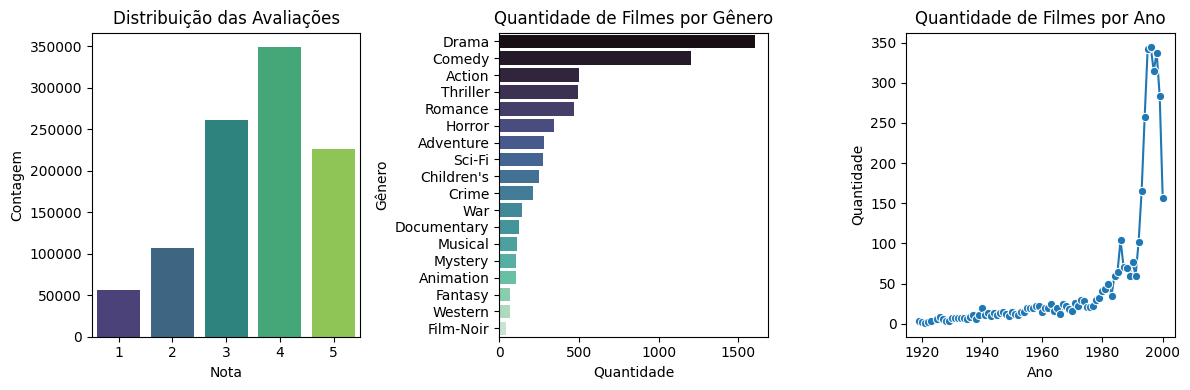

In [43]:
# Distribuição das avaliações por nota
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.countplot(x='Rating', data=ratings_df, palette='viridis')
plt.title('Distribuição das Avaliações')
plt.xlabel('Nota')
plt.ylabel('Contagem')

# Distribuição dos gêneros
plt.subplot(1, 3, 2)
genre_counts = movies_df_encoded[genres_list].sum().sort_values(ascending=False)
sns.barplot(y=genre_counts.index, x=genre_counts.values, palette='mako')
plt.title('Quantidade de Filmes por Gênero')
plt.xlabel('Quantidade')
plt.ylabel('Gênero')

# Quantidade de filmes por ano
plt.subplot(1, 3, 3)
movies_df_encoded['Year'] = movies_df_encoded['Title'].str.extract(r'\((\d{4})\)').astype(float)
year_counts = movies_df_encoded['Year'].value_counts().sort_index()
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o')
plt.title('Quantidade de Filmes por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade')

plt.tight_layout()
plt.show()

Gráficos de avaliações por gênero:
1. Por número de avaliações, que se mostra proporcional ao número de filmes do gênero.
2. Por nota média das avaliações, que mostra pequenas variações na médiia para um gênero ou outro, nada muito discrepante.

/tmp/ipykernel_5793/605424441.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(genre_ratings_count.keys()), y=list(genre_ratings_count.values()), palette='viridis')
/tmp/ipykernel_5793/605424441.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(genre_ratings_mean.keys()), y=list(genre_ratings_mean.values()), palette='mako')


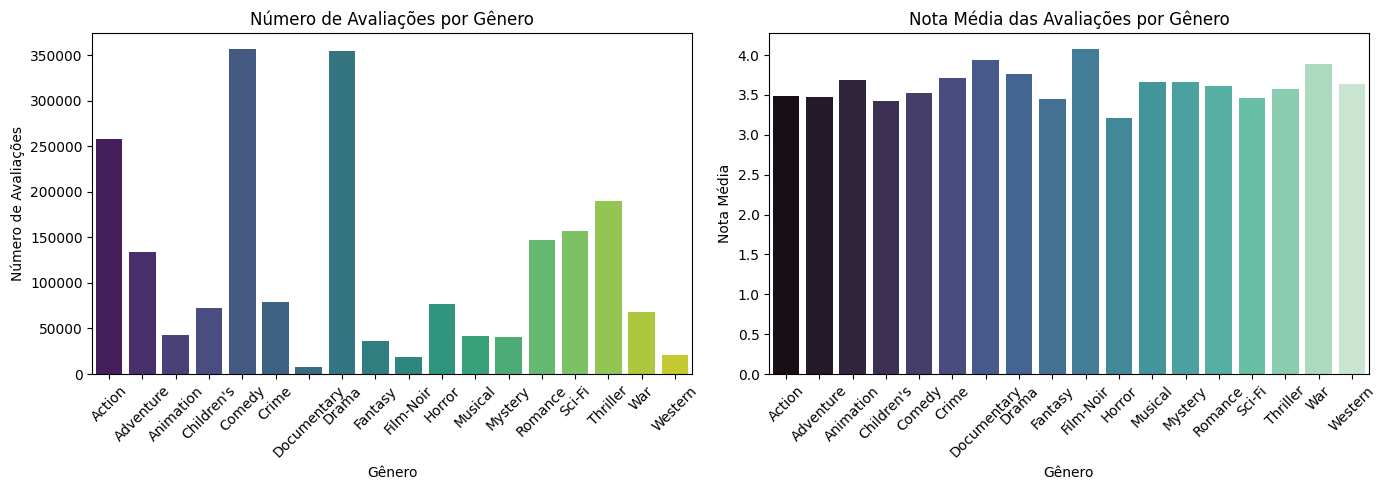

In [44]:
# 1. Número de avaliações por gênero
genre_ratings_count = {}
for genre in genres_list:
    # Seleciona os MovieIDs dos filmes desse gênero
    movie_ids = movies_df_encoded[movies_df_encoded[genre] == 1]['MovieID']
    # Conta quantas avaliações existem para esses filmes
    count = ratings_df[ratings_df['MovieID'].isin(movie_ids)].shape[0]
    genre_ratings_count[genre] = count

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=list(genre_ratings_count.keys()), y=list(genre_ratings_count.values()), palette='viridis')
plt.title('Número de Avaliações por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Número de Avaliações')
plt.xticks(rotation=45)

# 2. Nota média das avaliações por gênero
genre_ratings_mean = {}
for genre in genres_list:
    movie_ids = movies_df_encoded[movies_df_encoded[genre] == 1]['MovieID']
    mean = ratings_df[ratings_df['MovieID'].isin(movie_ids)]['Rating'].mean()
    genre_ratings_mean[genre] = mean

plt.subplot(1, 2, 2)
sns.barplot(x=list(genre_ratings_mean.keys()), y=list(genre_ratings_mean.values()), palette='mako')
plt.title('Nota Média das Avaliações por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Nota Média')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Pré-processamento

## Duplicatas

Para verificação de duplicatas, usa-se MovieID para os filmes, e 'userID' junto com 'MovieID' para as avaliações.

In [45]:
# Verificando valores duplicados nos principais dataframes
print("Duplicados em ratings_df:", ratings_df.duplicated(subset=['UserID', 'MovieID'], keep=False).sum())
print("Duplicados em movies_df:", movies_df_encoded.duplicated(subset=['MovieID']).sum())

Duplicados em ratings_df: 0
Duplicados em movies_df: 0


## Feature Engineering 2: Separação de timestamp em 'bins' para o dataSet de avaliações

Criação de 10 períodos históricos e de coluna indicando o período de cada avaliação

In [46]:
ratings_df['Date'] = pd.to_datetime(ratings_df['Timestamp'], unit='s').sort_values(ascending=True)

In [47]:
# Criando bins diretamente a partir da coluna 'Date' em ratings_df, usando inteiros de 1 a 10 como labels
date_bins = pd.cut(
    ratings_df['Date'],
    bins=10,
    labels=range(1, 11)
)
ratings_df['Date_Period'] = date_bins.astype(int)
ratings_df.drop(inplace=True, columns=['Date'])

In [48]:
ratings_df_encoded = ratings_df.copy().drop(columns=['Timestamp'])

## Feature Engineering 3: Extrair informação da data de lançamento do filme para o dataSet de filmes

In [49]:
movies_df_encoded['Year'] = movies_df_encoded['Title'].str.extract(r'\((\d{4})\)').astype(int)

In [50]:
le = LabelEncoder()
movies_df_encoded['Year_Label'] = le.fit_transform(movies_df_encoded['Year'])

## Transformar colunas de identificação em index

In [51]:
ratings_df_encoded

,UserID,MovieID,Rating,Date_Period
0,1,1193,5,3
1,1,661,3,3
2,1,914,3,3
3,1,3408,4,3
4,1,2355,5,3
...,...,...,...,...
1000204,6040,1091,1,1
1000205,6040,1094,5,1
1000206,6040,562,5,1
1000207,6040,1096,4,1


In [52]:
movies_df_encoded.index = movies_df_encoded['MovieID']

## Juntar informações (Agregra informações do filme às avaliações)

In [53]:
ratings_df_final = ratings_df_encoded.merge(movies_df_encoded, left_on='MovieID', right_index=True, how='left')
ratings_df_final.drop(columns=['MovieID_x', 'MovieID_y', 'Title','Year'], inplace=True)
ratings_df_final.rename(columns={'Date_Period': 'Review_Date_Period' , 'Year_Label': 'Production_Year_Label'}, inplace=True)

In [54]:
ratings_df_final

,MovieID,UserID,Rating,Review_Date_Period,Action,Adventure,Animation,Children's,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Production_Year_Label
0,1193,1,5,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,55
1,661,1,3,3,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,76
2,914,1,3,3,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,44
3,3408,1,4,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,80
4,2355,1,5,3,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,1091,6040,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,69
1000205,1094,6040,5,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,72
1000206,562,6040,5,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,75
1000207,1096,6040,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,62


Aplicar aleatoriedade na ordem dos dados, a fim de posteriormente dividir os dados sem tedências

In [55]:
ratings_df_final = ratings_df_final.sample(frac=1, random_state=42).reset_index(drop=True)

## Normalização dos dados

Para que algorítimos de clusterização não dê mais significância para uma variável do que outra, é importante normalizar.

In [56]:
# Normalização do ratings_df_final
cols_to_normalize = ratings_df_final.columns.difference(['MovieID', 'UserID'])
scaler = StandardScaler()
ratings_df_final[cols_to_normalize] = scaler.fit_transform(ratings_df_final[cols_to_normalize])

In [57]:
ratings_df_final

,MovieID,UserID,Rating,Review_Date_Period,Action,Adventure,Animation,Children's,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Production_Year_Label
0,2683,5412,-1.415775,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.857372
1,904,5440,1.269747,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,...,-0.13637,-0.287549,-0.208142,4.888194,-0.415944,-0.431981,2.067157,-0.271205,-0.145311,-2.279046
2,3717,368,0.374573,0.475069,1.698516,-0.393236,-0.212702,-0.278899,-0.744322,3.40217,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.927070
3,1721,425,0.374573,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,...,-0.13637,-0.287549,-0.208142,-0.204575,2.404167,-0.431981,-0.483756,-0.271205,-0.145311,0.717975
4,3697,4942,-2.310949,-0.950503,1.698516,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,2.314919,2.067157,-0.271205,-0.145311,0.230088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,1077,1586,1.269747,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,2.314919,-0.483756,-0.271205,-0.145311,-0.954781
1000205,2700,2129,1.269747,-0.237717,-0.588749,-0.393236,4.701409,-0.278899,1.343505,-0.29393,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.857372
1000206,3102,854,-0.520601,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,2.067157,-0.271205,-0.145311,-0.118403
1000207,3479,4033,1.269747,-0.950503,-0.588749,2.543003,-0.212702,-0.278899,-0.744322,-0.29393,...,-0.13637,-0.287549,-0.208142,-0.204575,2.404167,-0.431981,-0.483756,-0.271205,-0.145311,-0.118403


## Criação de um DF separado sem variáveis de identificação : ['MovieID', 'UserID']

In [58]:
ratings_train_df = ratings_df_final.drop(columns=['MovieID', 'UserID']).copy()

## Redução de dimensionalidade com PCA

Teste do PCA e plot de 'importância'/variância explicada das componentes

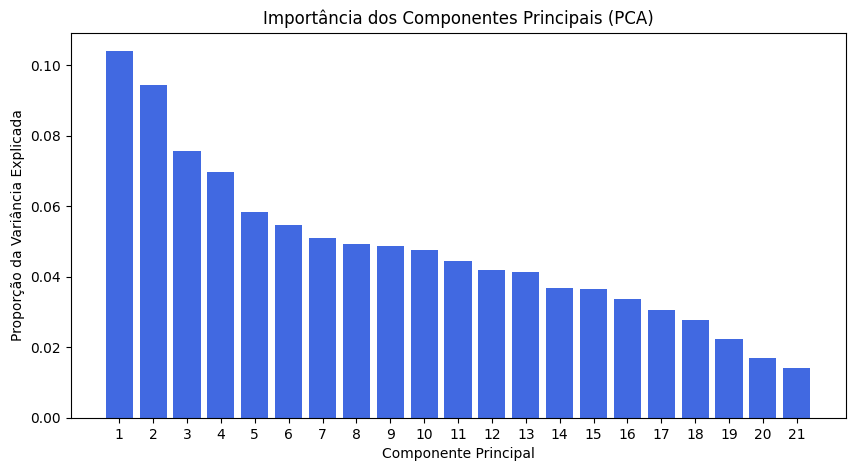

In [59]:
# Executando PCA
pca = PCA()
pca.fit(ratings_train_df)

# Plotando a importância (variância explicada) de cada componente
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, color='royalblue')
plt.xlabel('Componente Principal')
plt.ylabel('Proporção da Variância Explicada')
plt.title('Importância dos Componentes Principais (PCA)')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.show()

O gráfico de 'variância' das componentes principais dá a entender que selecionar poucas componentes pode ocasionar perda na variância dos dados, fazendo com que se perca informação. Foram realizados testes selecionando 3, 5 ou 10 componentes principais, e foi observado que sempre havia perda de informação, prejudicando os modelos de clusterização.

Criação de DF com 'n_comp' componentes principais.

In [60]:
# Reduzindo ratings_train_df para 5 componentes principais com PCA
n_comp = 10
pca = PCA(n_components=n_comp)
ratings_train_df_pca = pca.fit_transform(ratings_train_df)
ratings_train_pca_df = pd.DataFrame(ratings_train_df_pca, columns=[f'PC{i+1}' for i in range(n_comp)])



## Divisão do dataSet em 10 conjuntos de Sampling (Para rodar no DBSCAN) (PCA e sem PCA)

In [61]:
# Dividindo ratings_train_df_pca em 10 amostras aproximadamente iguais
ratings_pca_df_dict = {}
ratings_movieid_dict = {}
n_splits = 10
split_size = len(ratings_train_pca_df) // n_splits

for i in range(n_splits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < n_splits - 1 else len(ratings_train_pca_df)
    ratings_pca_df_dict[i] = ratings_train_pca_df.iloc[start_idx:end_idx].reset_index(drop=True)
    ratings_movieid_dict[i] = ratings_df_final['MovieID'].iloc[start_idx:end_idx].reset_index(drop=True)


In [62]:
ratings_pca_df_dict[0]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,0.604671,-0.450070,-0.957239,-1.701406,-0.082081,0.247301,0.120725,0.187883,-0.270737,-0.808700
1,-1.076852,-0.437329,3.896776,0.216048,0.824245,1.740655,0.699686,-0.568203,0.616493,-0.299663
2,-1.377915,-0.018774,0.490941,-0.339732,-1.726328,-0.574288,-0.357353,1.434195,-0.560377,-0.193797
3,0.216416,-1.697141,-0.775638,0.641605,-0.744340,-0.178341,0.952825,-0.548616,0.313304,0.494465
4,-2.371272,2.014537,0.043904,-1.159178,0.256372,-1.055245,0.788863,0.482717,-0.232405,-0.492209
...,...,...,...,...,...,...,...,...,...,...
100015,0.963171,-0.941329,-1.199252,-0.853911,0.171306,1.425047,1.705268,0.025107,0.362795,-0.675243
100016,0.851340,-0.620851,-0.379713,-0.594911,0.503704,0.813317,-0.233423,0.097202,0.120757,0.334650
100017,0.701809,-0.219957,0.118232,-1.441030,3.193841,0.300948,-0.289786,-1.412090,-0.635252,-0.670330
100018,0.636048,-1.620691,-0.653197,0.050505,-0.603152,0.025727,-0.620410,-0.014725,-0.024698,0.112807


In [63]:
# Dividindo ratings_train_df em 10 amostras aproximadamente iguais
ratings_df_dict = {}
ratings_movieid_dict2 = {}
n_splits = 10
split_size = len(ratings_train_df) // n_splits

for i in range(n_splits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < n_splits - 1 else len(ratings_train_df)
    ratings_df_dict[i] = ratings_train_df.iloc[start_idx:end_idx].reset_index(drop=True)
    ratings_movieid_dict2[i] = ratings_df_final['MovieID'].iloc[start_idx:end_idx].reset_index(drop=True)


In [64]:
ratings_df_dict[0]

,Rating,Review_Date_Period,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Production_Year_Label
0,-1.415775,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.857372
1,1.269747,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,4.888194,-0.415944,-0.431981,2.067157,-0.271205,-0.145311,-2.279046
2,0.374573,0.475069,1.698516,-0.393236,-0.212702,-0.278899,-0.744322,3.40217,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.927070
3,0.374573,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,1.349531,...,-0.13637,-0.287549,-0.208142,-0.204575,2.404167,-0.431981,-0.483756,-0.271205,-0.145311,0.717975
4,-2.310949,-0.950503,1.698516,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,2.314919,2.067157,-0.271205,-0.145311,0.230088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100015,-0.520601,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,2.404167,-0.431981,-0.483756,-0.271205,-0.145311,-0.188101
100016,0.374573,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,-0.606290
100017,-0.520601,-0.237717,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,-0.740998,...,-0.13637,3.477663,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,-1.860857
100018,1.269747,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,1.349531,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.857372


# Algorítimos de classificação

Definir flag de benchmark e qual DF usar adiante.

In [33]:
benchmark = True

## K-Médias - Sem PCA

### Benchmark de diversos números de cluster's

Irei primeiro usar o 'Método do cotovelo' para identificar um número bom de clusters. Basicamente, verifica-se em que número de cluster's a distância entre pontos de um mesmo grupo começa a cair menos.


In [115]:
if (benchmark):
    inertia = []
    silhouette_scores = []
    k_range = range(2, 50)  # silhouette_score requires at least 2 clusters

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans_nopca_labels = kmeans.fit_predict(ratings_train_df)
        inertia.append(kmeans.inertia_)
        #score = silhouette_score(ratings_train_df, labels)
        #silhouette_scores.append(score)


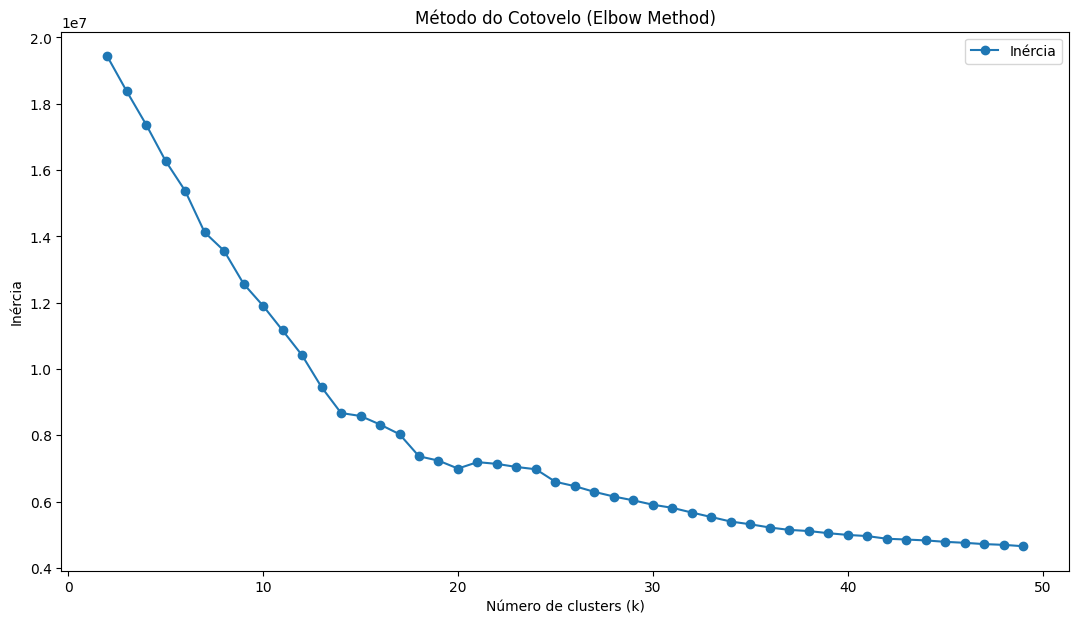

In [ ]:
if(benchmark):
    plt.figure(figsize=(13, 7))
    plt.plot(k_range, inertia, marker='o', label='Inércia')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Inércia')
    plt.title('Método do Cotovelo (Elbow Method)')
    plt.legend()
    plt.show()



### Execução do K-Means com 25 cluster's

In [118]:
kmeans_25 = KMeans(n_clusters=25, random_state=42)
clusters_25 = kmeans_25.fit_predict(ratings_train_df)

Plot do número de amostras em cada cluster para esse modelo / tipo de processamento.

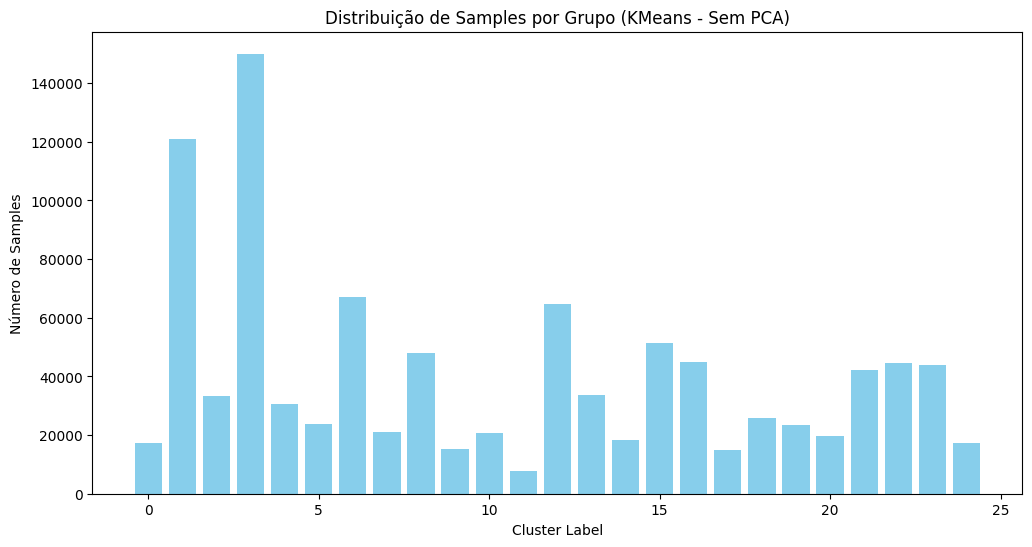

In [119]:
import numpy as np

unique_labels, counts = np.unique(clusters_25, return_counts=True)
plt.figure(figsize=(12, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Número de Samples')
plt.title('Distribuição de Samples por Grupo (KMeans - Sem PCA)')
plt.show()

Distrbuição com um máximo de 14 % das amostras em um mesmo cluster.

## K-Médias com PCA

### Benchmark de diversos números de cluster's

Irei primeiro usar o 'Método do cotovelo' para identificar um número bom de clusters. Basicamente, verifica-se em que número de cluster's a distância entre pontos de um mesmo grupo começa a cair menos.


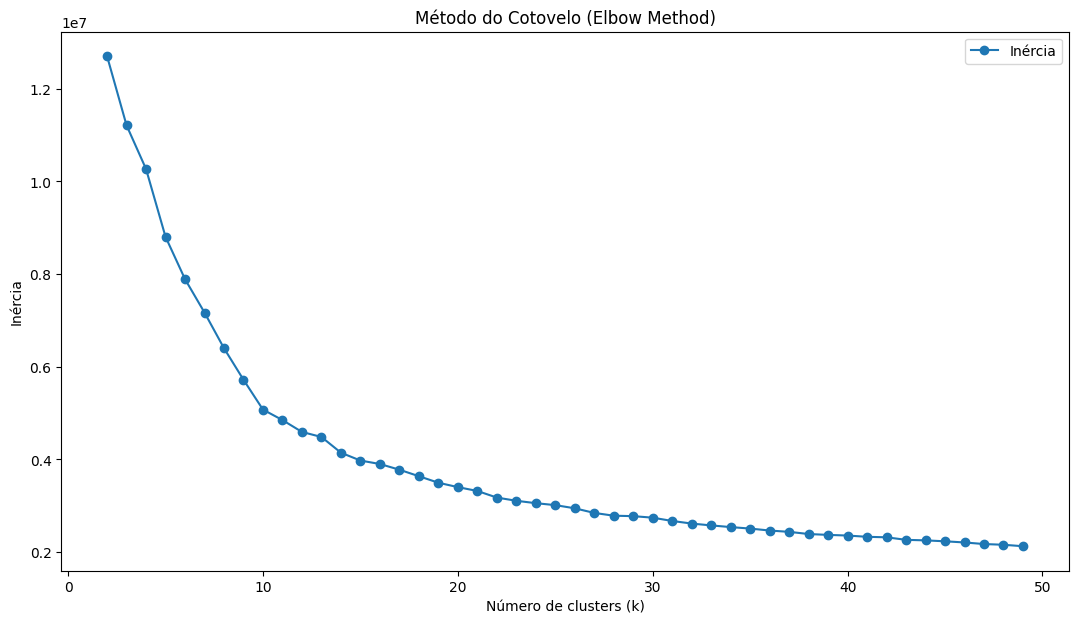

In [ ]:
if (benchmark):
    inertia = []
    silhouette_scores = []
    k_range = range(2, 50)  # silhouette_score requires at least 2 clusters

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans_pca_labels = kmeans.fit_predict(ratings_train_pca_df)
        inertia.append(kmeans.inertia_)
        #score = silhouette_score(ratings_train_df, labels)
        #silhouette_scores.append(score)

if(benchmark):
    plt.figure(figsize=(13, 7))
    plt.plot(k_range, inertia, marker='o', label='Inércia')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Inércia')
    plt.title('Método do Cotovelo (Elbow Method)')
    plt.legend()
    plt.show()

### Execução do K-Means com 25 cluster's

In [121]:
kmeans_25 = KMeans(n_clusters=25, random_state=42)
clusters_25_pca = kmeans_25.fit_predict(ratings_train_pca_df)

Plot do número de amostras em cada cluster para esse modelo / tipo de processamento.

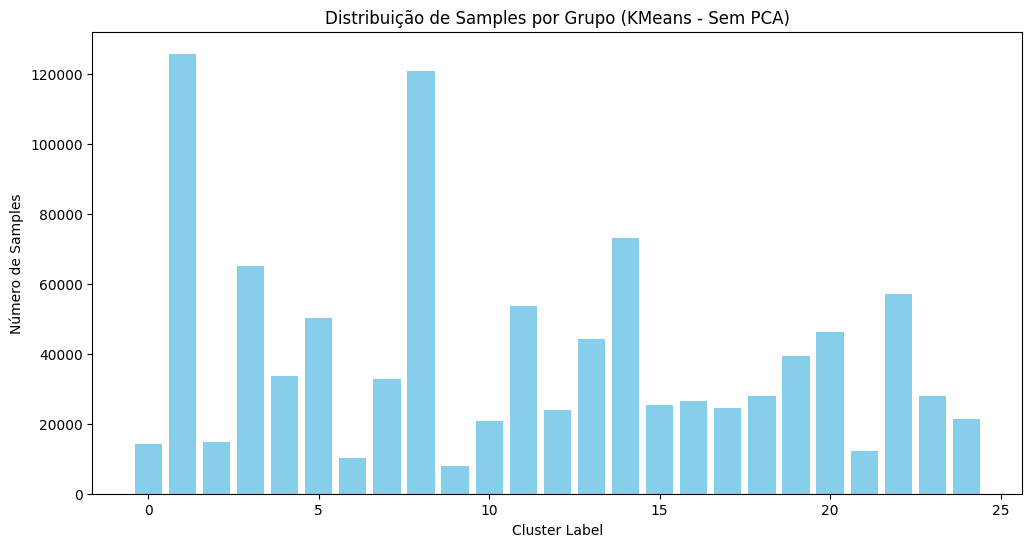

In [ ]:
unique_labels, counts = np.unique(clusters_25_pca, return_counts=True)
plt.figure(figsize=(12, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Número de Samples')
plt.title('Distribuição de Samples por Grupo (KMeans - Sem PCA)')
plt.show()

K-means utilizando o PCA mostra uma distribuição de cluster's similar ao K-means sem PCA. ( Máximo de 12 % das amostras em um mesmo cluster)
Vale lembrar que essa comparação é feita com ambos tendo o mesmo número de clusters = 25.

## DBSCAN - com PCA

In [34]:
ratings_pca_df_dict[0]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,0.604671,-0.450070,-0.957239,-1.701406,-0.082081,0.247301,0.120725,0.187883,-0.270737,-0.808700
1,-1.076852,-0.437329,3.896776,0.216048,0.824245,1.740655,0.699686,-0.568203,0.616493,-0.299663
2,-1.377915,-0.018774,0.490941,-0.339732,-1.726328,-0.574288,-0.357353,1.434195,-0.560377,-0.193797
3,0.216416,-1.697141,-0.775638,0.641605,-0.744340,-0.178341,0.952825,-0.548616,0.313304,0.494465
4,-2.371272,2.014537,0.043904,-1.159178,0.256372,-1.055245,0.788863,0.482717,-0.232405,-0.492209
...,...,...,...,...,...,...,...,...,...,...
100015,0.963171,-0.941329,-1.199252,-0.853911,0.171306,1.425047,1.705268,0.025107,0.362795,-0.675243
100016,0.851340,-0.620851,-0.379713,-0.594911,0.503704,0.813317,-0.233423,0.097202,0.120757,0.334650
100017,0.701809,-0.219957,0.118232,-1.441030,3.193841,0.300948,-0.289786,-1.412090,-0.635252,-0.670330
100018,0.636048,-1.620691,-0.653197,0.050505,-0.603152,0.025727,-0.620410,-0.014725,-0.024698,0.112807


Após teste, foi constatado que o DBSCAN não consegue rodar com o número de dimensões do dataSet montado. Mesmo usando PCA para reduzir a dimensionalidade, o algorítimo usava toda a memória do sistema (32 GB). Sendo assim, o dataSet foi particionado em 10 para rodar o DBSCAN.

Rodando com 1/10 das linhas e 10 componentes principais.

In [38]:
dbscan = DBSCAN(eps=2, min_samples=5, n_jobs=10)
dbscan_labels = dbscan.fit_predict(ratings_pca_df_dict[0])

Total unique labels: 37


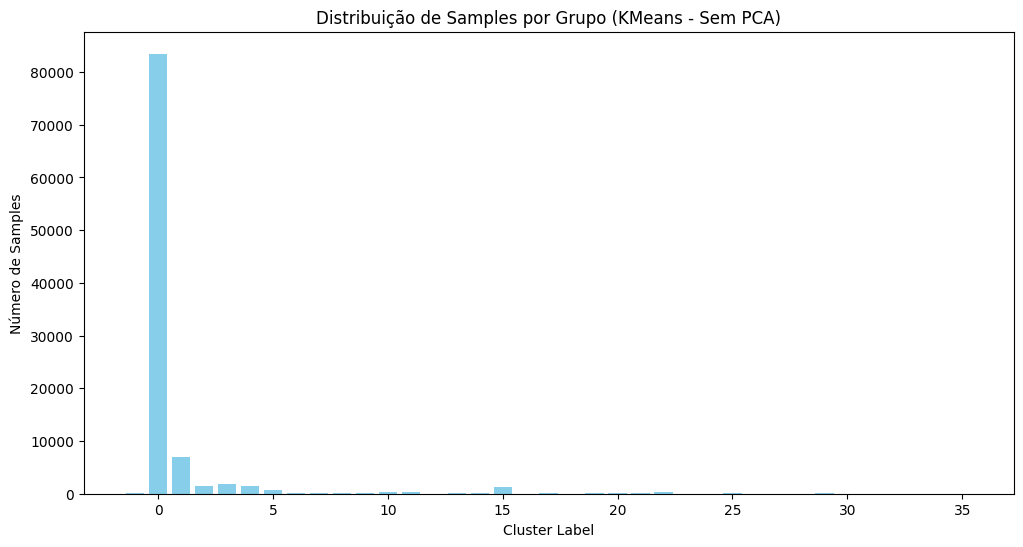

In [41]:
import numpy as np

unique_labels, counts = np.unique(dbscan_labels, return_counts=True)
print(f"Total unique labels: {len(unique_labels)}")

plt.figure(figsize=(12, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Número de Samples')
plt.title('Distribuição de Samples por Grupo (KMeans - Sem PCA)')
plt.show()

Rodando DBSCAN usando PCA com 10 componentes principais (eps = 2 ; min_samples=5) resultou em 37 grupos, sendo que um deles sempre concentrada em torno de 83% das amostras de treino.

Isso mostra uma dificuldade de clusterização usando PCA.

## DBSCAN - Sem PCA

In [42]:
ratings_df_dict[0]

,Rating,Review_Date_Period,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Production_Year_Label
0,-1.415775,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.857372
1,1.269747,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,4.888194,-0.415944,-0.431981,2.067157,-0.271205,-0.145311,-2.279046
2,0.374573,0.475069,1.698516,-0.393236,-0.212702,-0.278899,-0.744322,3.40217,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.927070
3,0.374573,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,1.349531,...,-0.13637,-0.287549,-0.208142,-0.204575,2.404167,-0.431981,-0.483756,-0.271205,-0.145311,0.717975
4,-2.310949,-0.950503,1.698516,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,2.314919,2.067157,-0.271205,-0.145311,0.230088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100015,-0.520601,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,2.404167,-0.431981,-0.483756,-0.271205,-0.145311,-0.188101
100016,0.374573,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,-0.606290
100017,-0.520601,-0.237717,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,-0.740998,...,-0.13637,3.477663,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,-1.860857
100018,1.269747,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,1.349531,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.857372


In [ ]:
dbscan = DBSCAN(eps=2, min_samples=5, n_jobs=10)
dbscan_labels = dbscan.fit_predict(ratings_df_dict[0])

Total unique labels: 295
Total samples per Split: 33340


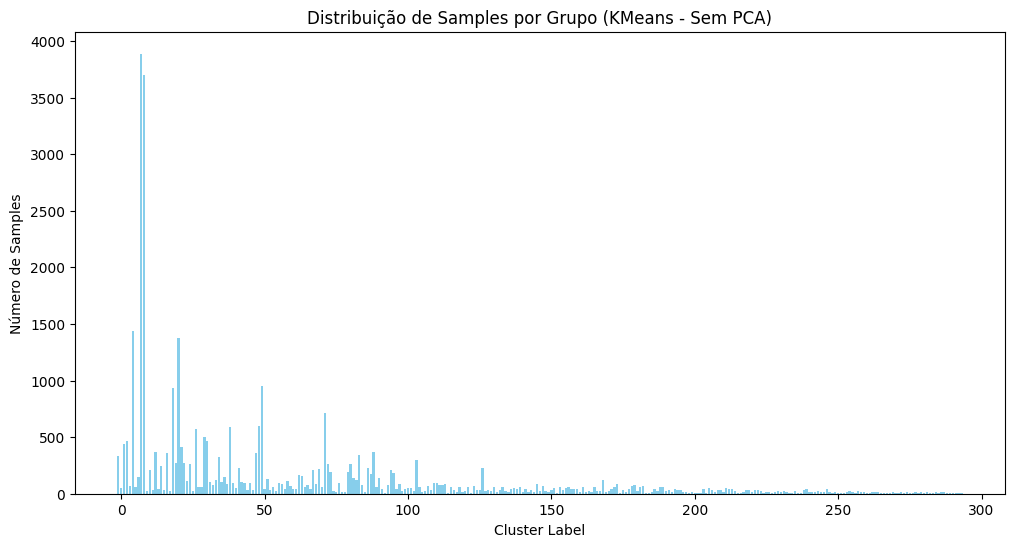

In [ ]:
import numpy as np

unique_labels, counts = np.unique(dbscan_labels, return_counts=True)
print(f"Total unique labels: {len(unique_labels)}")
print(f"Total samples per Split: {len(ratings_df_dict[0])}")
plt.figure(figsize=(12, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Número de Samples')
plt.title('Distribuição de Samples por Grupo (KMeans - Sem PCA)')
plt.show()

Sem utilizar PCA, a concentração de amostras em um cluster é menor. Porém, o DBSCAN acha um número bem alto de clusters em relação ao K-Médias.


## Clustering Hierarquico - Aglomerativo

Por definição, o clustering hierarquico irá utilizar muita memória. Ao testar com o dataSet inteiro, foi solicitado 3.64 TiB de memória (e o kernel deu erro).

Portanto, após testes com splits de 10 e 20 conjuntos, apenas consegui rodar o código em minha máquina utilizando 30 Splits.

In [ ]:
# Dividindo ratings_train_df em 'n' amostras aproximadamente iguais
ratings_df_dict2 = {}
ratings_movieid_dict3 = {}
n_splits = 30
split_size = len(ratings_train_df) // n_splits

for i in range(n_splits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < n_splits - 1 else len(ratings_train_df)
    ratings_df_dict2[i] = ratings_train_df.iloc[start_idx:end_idx].reset_index(drop=True)
    ratings_movieid_dict2[i] = ratings_df_final['MovieID'].iloc[start_idx:end_idx].reset_index(drop=True)


In [ ]:
# Clustering Hierárquico Aglomerativo usando o ratings_train_df
agg_cluster = AgglomerativeClustering(n_clusters=25)
agg_labels = agg_cluster.fit_predict(ratings_df_dict2[0])


Total unique labels: 25
Total samples per Split: 33340


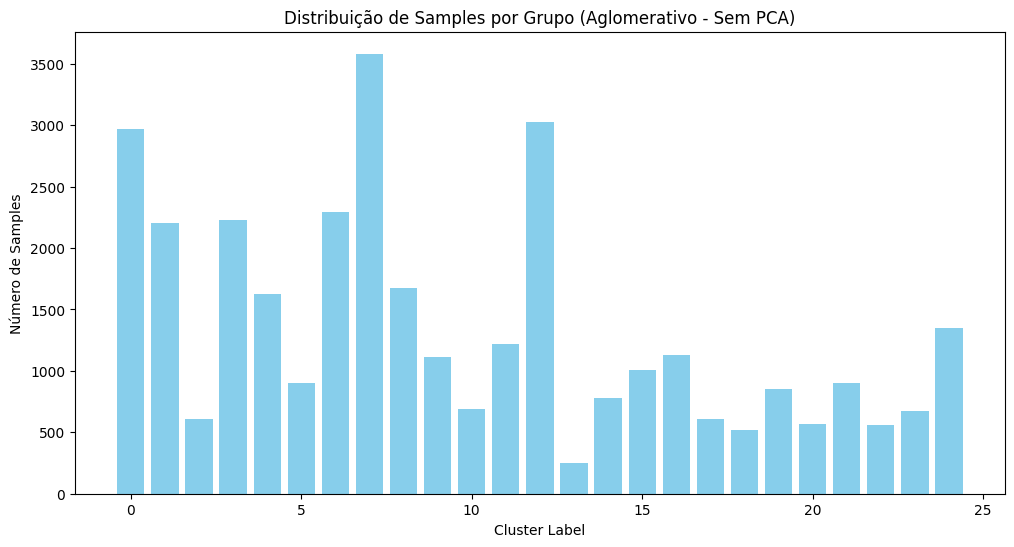

In [77]:
# Plotando a distribuição dos samples por cluster
unique_labels, counts = np.unique(agg_labels, return_counts=True)

print(f"Total unique labels: {len(unique_labels)}")
print(f"Total samples per Split: {len(ratings_df_dict2[0])}")

plt.figure(figsize=(12, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Número de Samples')
plt.title('Distribuição de Samples por Grupo (Aglomerativo - Sem PCA)')
plt.show()